In [1]:
import numpy as np, prjlib, plottools as pl, healpy as hp, curvedsky, tools_lens, tools_delens, tools_multitracer, binning, tqdm
from matplotlib.pyplot import *

In [7]:
snmin, snmax = 1, 100
olmax = 1024
ntypes = ['base','goal']
#tracer = ['all','cmb','mass']
tracer = ['all','cmb','gal','cib']
labels = ['All','CMB','LSST','CIB']
colors = ['m','b','g','c']

In [3]:
d = prjlib.data_directory()
dobj = {}
for ntype in ntypes:
    Ntype = ntype.replace('_la','')+'_roll50'
    p = prjlib.analysis_init(t='la',freq='com',fltr='none',snmin=snmin,snmax=snmax,ntype=Ntype)
    pE = prjlib.analysis_init(t='co',freq='com',fltr='cinv',ntype=Ntype.replace('_iso',''))
    qobj = tools_lens.init_qobj(p.stag,'False',rlmin=300,rlmax=4096)
    for mass in tracer:
        if mass == 'cmb':
            mobj = tools_multitracer.mass_tracer(p,qobj,add_gal=[],add_cib=False)
        if mass == 'mass':
            mobj = tools_multitracer.mass_tracer(p,qobj,add_cmb=[])
        if mass == 'gal':
            mobj = tools_multitracer.mass_tracer(p,qobj,add_cmb=[],add_cib=False)
        if mass == 'cib':
            mobj = tools_multitracer.mass_tracer(p,qobj,add_cmb=[],add_gal=[])
        if mass == 'all':
            mobj = tools_multitracer.mass_tracer(p,qobj)
        dobj[ntype,mass] = tools_delens.init_template(p.stag+qobj.ltag,mobj,pE,False,elmin=50)

In [4]:
r = {}
for ntype in ntypes:
    for mass in tracer:
        r[ntype,mass] = 0
        for i in tqdm.tqdm(range(snmin,snmax+1),desc=ntype+','+mass):
            BB, TT, BT = np.loadtxt(dobj[ntype,mass].cl['comb'][i],unpack=True)
            r[ntype,mass] += BT**2/BB/TT/(snmax-snmin+1)

base,all:   0%|          | 0/100 [00:00<?, ?it/s]/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
goal,cib: 100%|██████████| 100/100 [00:02<00:00, 49.65it/s]


In [5]:
rb = {}
mb = binning.multipole_binning(20,lmin=5,lmax=200)
for ntype in ntypes:
    for mass in tracer:
        rb[ntype,mass] = binning.binning(r[ntype,mass],mb)

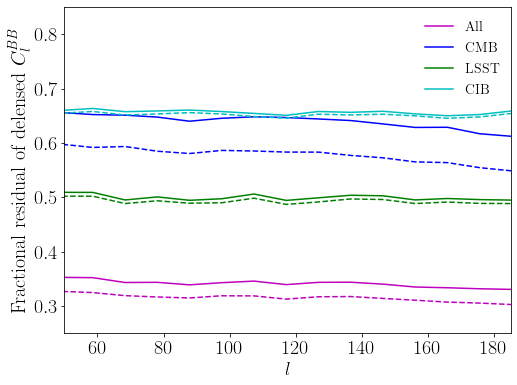

In [8]:
import matplotlib.pyplot as plt
params = {
    'figure.figsize':[8,6],
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': True,
    'font.family': "Times New Roman", 
    }
plt.rcParams.update(params)
xlim(50,185)
ylim(0.25,.85)
xlabel(r'$l$',fontsize=18)
ylabel(r'Fractional residual of delensed $C^{BB}_l$',fontsize=20)
for mass, label, color in zip(tracer,labels,colors):
    plot(mb.bc,1-rb['base',mass],label=label,color=color)
    plot(mb.bc,1-rb['goal',mass],color=color,ls='--')
legend(loc=0)
savefig('fig_BB_correlation_each.pdf')